Importy bibliotek

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split
import seaborn as sns
from sklearn.metrics import hamming_loss, f1_score
from tensorflow.python.keras.utils.version_utils import callbacks

Wczytanie danych, przetwarzanie i inżynieria cech

In [81]:
FILE = 'data/stan_ustalony_gotowe.csv'

# Lista cech
SELECTED_FEATURES = [
    'Active Power 1 (Cycle) [W]',
    'Reactive Power 1 (Cycle) [VAr]',
    'Power Factor 1 (Cycle) (Load)',
    'RMS - non-Fundamental I1 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]',
]

# Urzadzenia 
# Usuniete phone_charger, usb_c_charger, decoder, lamp oraz hair_dryer
# Tymczasowe usuniecie induction_cooker, mixer, toaster, spin dryer, printer, baathroom_heater, sandwich_maker
DEVICE_COLUMNS = [
    'kettle', 
    #'induction_cooker',
    'microwave', 
    #'mixer',
    #'toaster',
    'tv', 
    #'spin_dryer', 
    'coffee_maker', 
    'immersion_heater',
    #'sandwich_maker', 
    'aquarium_heater', 
    'heater',
    'laptop', 
    'christmas_tree', 
    'timer',
    'fridge', 
    #'printer', 
    #'bathroom_heater', 
    'Monitor',
    #'phone_charger', 
    #'usb_c_charger', 
    #'decoder', 
    #'hair_dryer'
]

# Wczytanie csv
df = pd.read_csv(FILE, sep=';', decimal=',')
df = df.iloc[:, :120]
# Usuwanie CAP/IND z Power Factor
def clean_power_factor(value):
    if isinstance(value, str):
        value = value.replace(' CAP', '').replace(' IND', '').strip()
        value = value.replace(',', '.')
    return value

# Czyszczenie powerfactor
PF_COLS = [col for col in SELECTED_FEATURES if 'Power Factor' in col]
for col in PF_COLS:
    df[col] = df[col].apply(clean_power_factor)

# Konwersja cech na typ numeryczny
for col in SELECTED_FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Wiersze przed czyszczeniem
print(f"Liczba wierszy przed czyszczeniem: {len(df)}")

Liczba wierszy przed czyszczeniem: 1316


In [82]:
# Zmienne dla nowych cech
col_v = 'RMS V1N (Cycle) [V]'
col_i = 'RMS I1 (Cycle) [A]'
col_p = 'Active Power 1 (Cycle) [W]'
col_q = 'Reactive Power 1 (Cycle) [VAr]'

# Sprawdzenie czy kolumny sa numeryczne
for col in [col_v, col_i, col_p, col_q]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Moc pozorna
df['S_total_calc'] = df[col_v] * df[col_i]

# Budeanu
# Wzór: D = sqrt(S^2 - P^2 - Q^2)
term_under_sqrt = (df['S_total_calc']**2) - (df[col_p]**2) - (df[col_q]**2)
df['Budeanu Distortion Power [VAr]'] = np.sqrt(np.maximum(term_under_sqrt, 0))

# Fryze

# Konduktancja Czynna (Gw)
# Gw = P / U^2
df['Fryze_Conductance'] = df[col_p] / (df[col_v] ** 2)

# Prąd Czynny Fryzego (Iw)
# Wzór: Iw = Gw * U
df['Fryze_Active_Current'] = df['Fryze_Conductance'] * df[col_v]

# Prąd Bierny Fryzego (Ib)
# Wzór: Ib = sqrt(I_calkowite^2 - Iw^2)
df['Fryze_Passive_Current'] = np.sqrt(np.maximum(df[col_i]**2 - df['Fryze_Active_Current']**2, 0))

# Moc Bierna Fryzego (Pb)
# Wzór: Pb = sqrt(S^2 - P^2)
df['Fryze_Passive_Power'] = np.sqrt(np.maximum(df['S_total_calc']**2 - df[col_p]**2, 0))

# Nowe cechy
NEW_FEATURES = [
    'Budeanu Distortion Power [VAr]',
    'Fryze_Conductance',
    'Fryze_Active_Current',
    'Fryze_Passive_Current',
    'Fryze_Passive_Power'
]

# Dodanie nowych cech do juz istniejacych
for feature in NEW_FEATURES:
    if feature not in SELECTED_FEATURES:
        SELECTED_FEATURES.append(feature)
        print(f"-> Dodano nową cechę: {feature}")

print(f"\nLiczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

-> Dodano nową cechę: Budeanu Distortion Power [VAr]
-> Dodano nową cechę: Fryze_Conductance
-> Dodano nową cechę: Fryze_Active_Current
-> Dodano nową cechę: Fryze_Passive_Current
-> Dodano nową cechę: Fryze_Passive_Power

Liczba cech: 11
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]', 'Budeanu Distortion Power [VAr]', 'Fryze_Conductance', 'Fryze_Active_Current', 'Fryze_Passive_Current', 'Fryze_Passive_Power']


In [83]:
# Zastapienie Inf/ -Inf na NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Zamiana NaN na 0
df[SELECTED_FEATURES] = df[SELECTED_FEATURES].fillna(0)

print(f"Wartości NaN/Inf zastąpiono zerami.")
print(f"Liczba wierszy: {len(df)}")

if len(df) == 0:
    raise ValueError("Zbiór danych jest pusty")

# Przygotowanie macierzy cech (X) i etykiet (y)
for col in DEVICE_COLUMNS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

X = df[SELECTED_FEATURES].values
y = df[DEVICE_COLUMNS].values

# Podział na zbiory treningowe/testowe i standaryzacja
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("-" * 30)
print(f"Wymiary X_train: {X_train_scaled.shape}, wymiary y_train: {y_train.shape}")
print(f"Liczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

Wartości NaN/Inf zastąpiono zerami.
Liczba wierszy: 1316
------------------------------
Wymiary X_train: (1052, 11), wymiary y_train: (1052, 12)
Liczba cech: 11
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]', 'Budeanu Distortion Power [VAr]', 'Fryze_Conductance', 'Fryze_Active_Current', 'Fryze_Passive_Current', 'Fryze_Passive_Power']


Analiza rozkładu klas (urządzeń) w zbiorach treningowych i testowych

In [84]:
# Zliczanie stanow ustalonych dla urzadzen
train_counts = y_train.sum(axis=0)
test_counts = y_test.sum(axis=0)
total_counts = train_counts + test_counts

# Podsumowanie
distribution_df = pd.DataFrame({
    'Device': DEVICE_COLUMNS,
    'Train (1s)': train_counts,
    'Test (1s)': test_counts,
    'Total (1s)': total_counts,
    'Share [%]': (total_counts / len(df) * 100).round(2)
})

# Sortowanie malejąco wg liczby wystąpień
distribution_df.sort_values(by='Total (1s)', ascending=False, inplace=True)

print("Rozkład aktywności urządzeń:")
try:
    display(distribution_df)
except NameError:
    print(distribution_df)

Rozkład aktywności urządzeń:


,Device,Train (1s),Test (1s),Total (1s),Share [%]
2,tv,518,130,648,49.24
10,fridge,314,78,392,29.79
7,laptop,227,58,285,21.66
3,coffee_maker,181,45,226,17.17
6,heater,143,36,179,13.60
5,aquarium_heater,141,35,176,13.37
8,christmas_tree,139,35,174,13.22
11,Monitor,122,31,153,11.63
9,timer,78,20,98,7.45
0,kettle,63,16,79,6.00


In [86]:
def plot_multilabel_heatmap(y_true, y_pred, labels, title, cmap='viridis'):
    """
    Generuje mapę ciepła pokazującą korelacje między faktycznymi a przewidywanymi etykietami.
    Wiersze: Faktycznie działające urządzenie
    Kolumny: Przewidziane działanie urządzenia
    """
    n_labels = len(labels)
    # Macierz: wiersz i - faktyczna klasa, kolumna j - ile razy przewidziano tę klasę
    confusion_matrix = np.zeros((n_labels, n_labels))
    
    for i in range(n_labels):
        # Znajdujemy wiersze, gdzie urządzenie 'i' faktycznie pracowało
        actual_present_mask = (y_true[:, i] == 1)
        if np.any(actual_present_mask):
            # Sumujemy wszystkie predykcje dla tych konkretnych przypadków
            confusion_matrix[i, :] = y_pred[actual_present_mask, :].sum(axis=0)
    
    # Normalizacja do procentów (opcjonalnie, ułatwia interpretację przy nierównych klasach)
    # confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True) * 100

    plt.figure(figsize=(14, 10))
    sns.heatmap(confusion_matrix, annot=False, fmt='.0f', cmap=cmap,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=16)
    plt.xlabel('Przewidziane urządzenia', fontsize=12)
    plt.ylabel('Faktycznie działające urządzenia', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Random Forest

Koniec treningu Random Forest.

Dokładność całkowita (Exact Match): 65.53%

Raport klasyfikacji:
                  precision    recall  f1-score   support

          kettle       0.87      0.81      0.84        16
       microwave       1.00      1.00      1.00         8
              tv       0.88      0.85      0.87       130
    coffee_maker       0.97      0.73      0.84        45
immersion_heater       0.79      0.92      0.85        12
 aquarium_heater       0.97      1.00      0.99        35
          heater       0.79      0.86      0.83        36
          laptop       0.68      0.59      0.63        58
  christmas_tree       0.97      1.00      0.99        35
           timer       0.76      0.95      0.84        20
          fridge       0.96      0.95      0.95        78
         Monitor       0.68      0.87      0.76        31

       micro avg       0.86      0.86      0.86       504
       macro avg       0.86      0.88      0.86       504
    weighted avg       0.87    

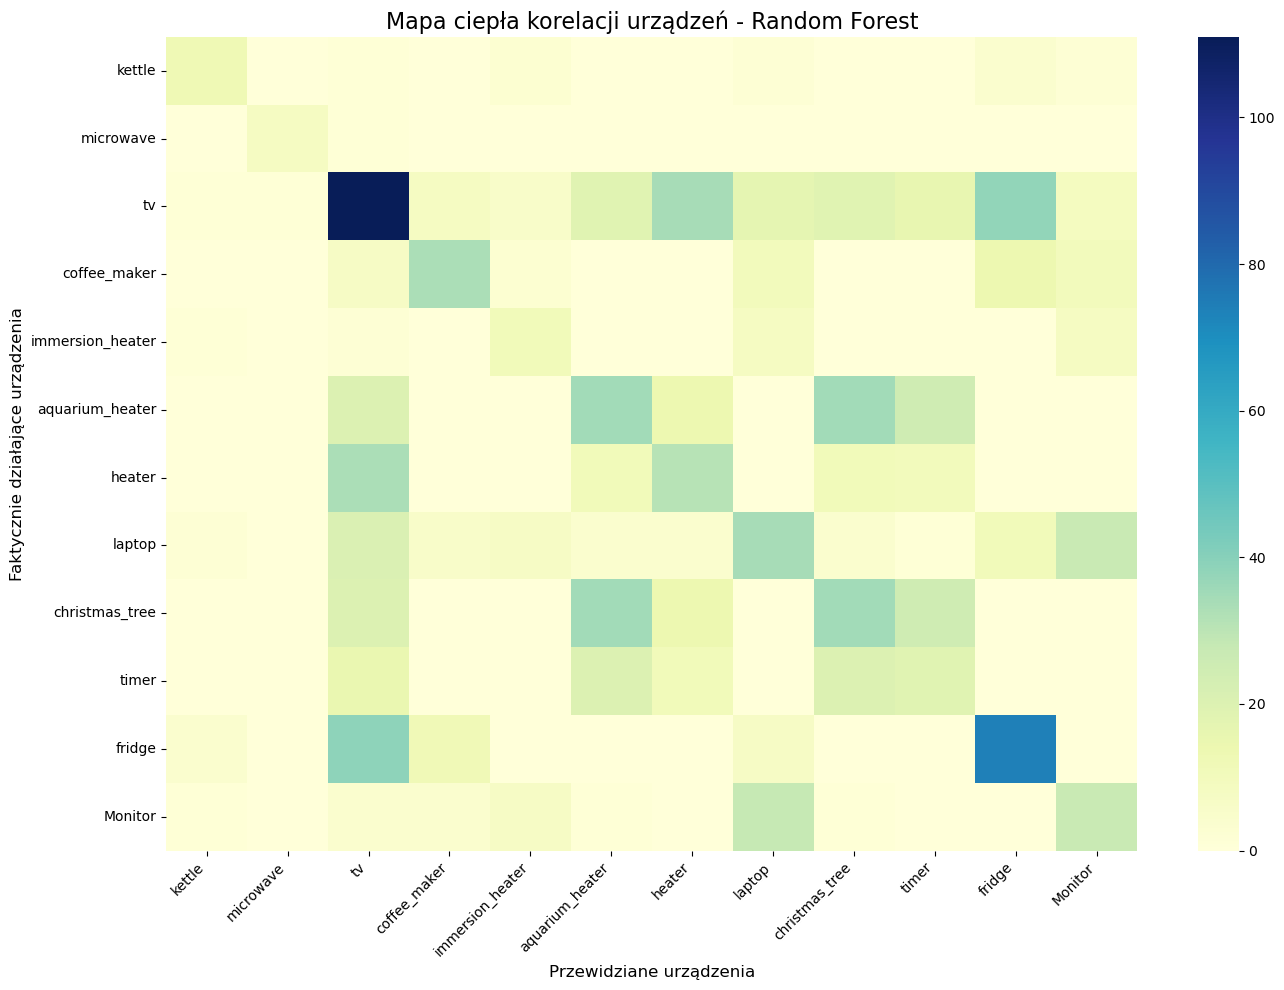

In [87]:
# Konfiguracja modelu
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model = RandomForestClassifier(
    n_estimators=320,        # większa liczba drzew
    max_depth=25,            # zmniejszona glebokosc
    min_samples_split=5,     # wezel musi miec min 5 probek do podzialu
    min_samples_leaf=2,      # lisc min 2 probki
    class_weight='balanced', # wieksze wagi dla mniejszościowych klas
    n_jobs=-1,               # Użycie wszystkich rdzeni CPU
    random_state=42
)

# Dopasowanie modelu do danych treningowych
rf_model.fit(X_train_scaled, y_train)
print("Koniec treningu Random Forest.")

# Predykcja na zbiorze testowym
y_pred = rf_model.predict(X_test_scaled)

# Obliczenie dokładności
acc = accuracy_score(y_test, y_pred)
print(f"\nDokładność całkowita (Exact Match): {acc:.2%}\n")

print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=DEVICE_COLUMNS, zero_division=0))

plot_multilabel_heatmap(
    y_test, 
    y_pred, 
    DEVICE_COLUMNS, 
    "Mapa ciepła korelacji urządzeń - Random Forest",
    cmap='YlGnBu'
)

Deep Neural Network (PyTorch)

TensorFlow version: 2.10.0
Dostępne urządzenia: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 64)                768       
                                                                 
 dropout_62 (Dropout)        (None, 64)                0         
                                                                 
 dense_94 (Dense)            (None, 32)                2080      
                                                                 
 dropout_63 (Dropout)        (None, 32)                0         
                                                                 
 dense_95 (Dense)            (None, 12)                396       
                                                                 
Total params: 3,244
Trainable params: 3,244
Non-trainable params: 0
__

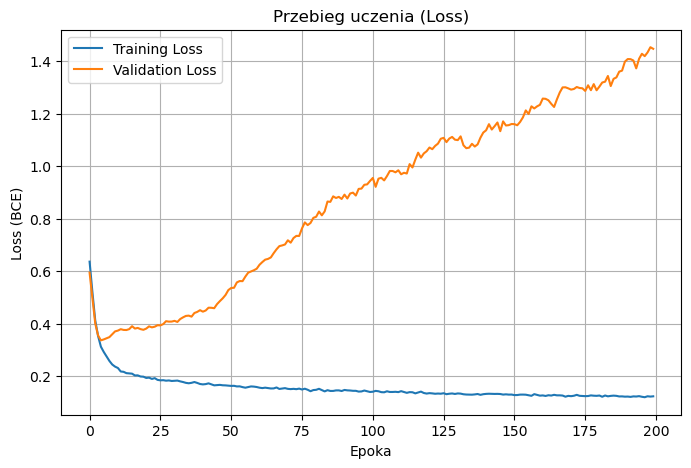

9/9 [==============================] - 0s 1ms/step
Hamming Loss: 0.0663
F1-Score (Samples): 74.28%
Szczegółowy raport klasyfikacji:
                  precision    recall  f1-score   support

          kettle       0.92      0.75      0.83        16
       microwave       1.00      1.00      1.00         8
              tv       0.88      0.61      0.72       130
    coffee_maker       0.91      0.71      0.80        45
immersion_heater       0.75      1.00      0.86        12
 aquarium_heater       1.00      1.00      1.00        35
          heater       0.60      0.08      0.15        36
          laptop       0.76      0.38      0.51        58
  christmas_tree       1.00      1.00      1.00        35
           timer       0.81      0.85      0.83        20
          fridge       0.91      0.81      0.86        78
         Monitor       0.75      0.68      0.71        31

       micro avg       0.88      0.67      0.76       504
       macro avg       0.86      0.74      0.77       

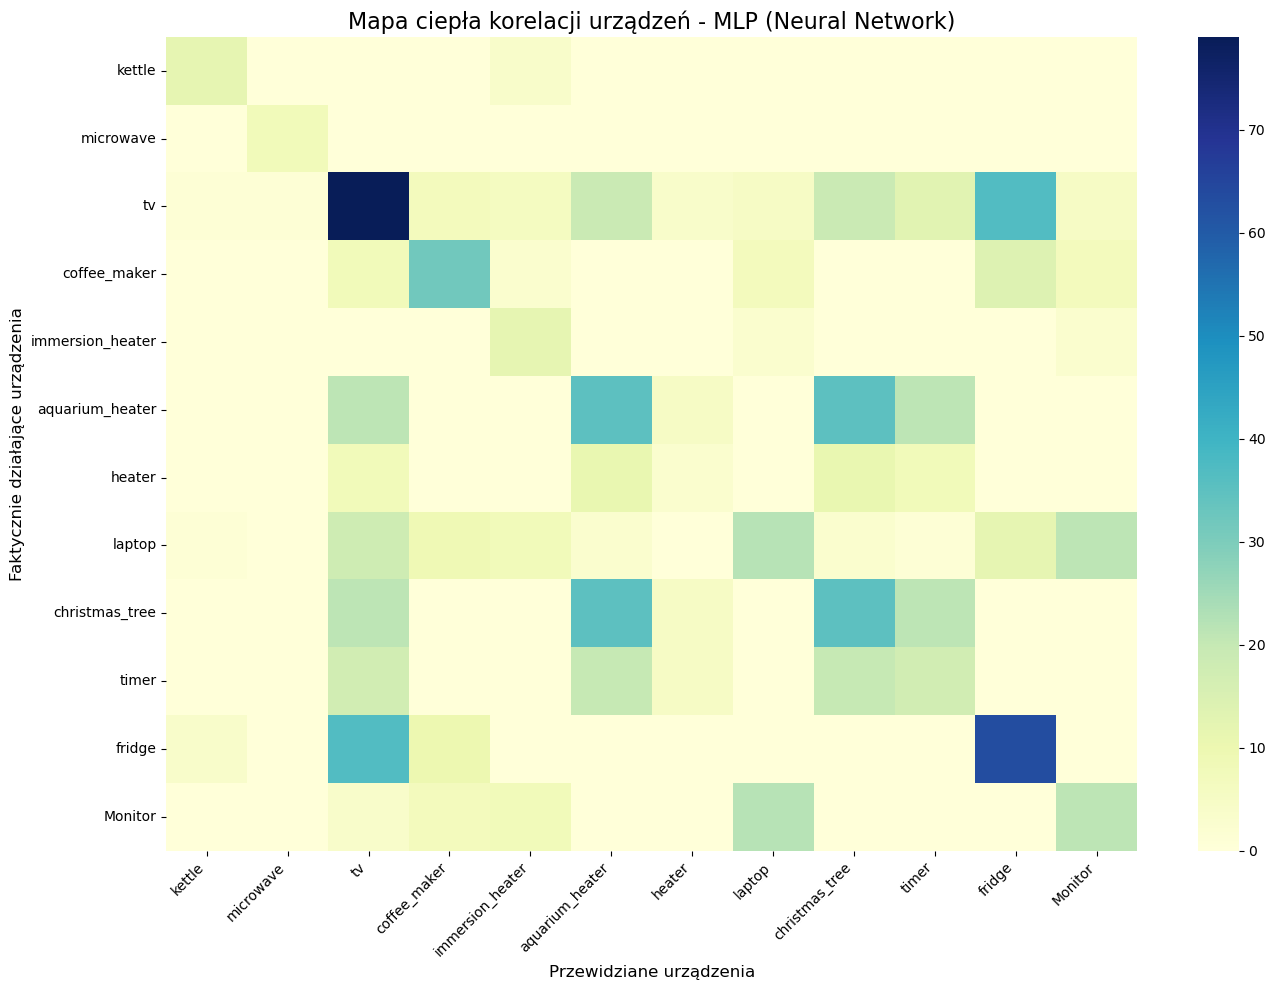

In [107]:
# Sprawdzenie dostępności GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"Dostępne urządzenia: {tf.config.list_physical_devices()}")

input_dim = X_train_scaled.shape[1]
output_dim = y_train.shape[1]

model = models.Sequential([
    # Warstwa wejściowa -> Ukryta 1
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),  # Zapobiega overfittingowi
    
    # Ukryta 1 -> Ukryta 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Warstwa wyjściowa
    layers.Dense(output_dim)
])

# Wyświetlenie podsumowania architektury
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    # from_logits=True to odpowiednik BCEWithLogitsLoss
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

EPOCHS = 200
BATCH_SIZE = 32

print("Rozpoczynam trening sieci neuronowej (TensorFlow)...")

history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Wykres funkcji straty
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Przebieg uczenia (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True)
plt.show()

# Predykcja zwraca "logits" (surowe wartości)
logits = model.predict(X_test_scaled)

# Konwersja logits -> prawdopodobieństwa (Sigmoid)
probs = tf.nn.sigmoid(logits).numpy()

# Binaryzacja wyników (Próg 0.5)
y_pred_numpy = (probs > 0.5).astype(int)

# Raport wyników
from sklearn.metrics import accuracy_score, classification_report
acc_dnn = accuracy_score(y_test, y_pred_numpy)

# Błąd Hamminga
h_loss = hamming_loss(y_test, y_pred_numpy)

# F1-Score Samples
f1_samples = f1_score(y_test, y_pred_numpy, average='samples', zero_division=1)

print(f"Hamming Loss: {h_loss:.4f}")
print(f"F1-Score (Samples): {f1_samples:.2%}")

print("Szczegółowy raport klasyfikacji:")
print(classification_report(y_test, y_pred_numpy, target_names=DEVICE_COLUMNS, zero_division=0))

plot_multilabel_heatmap(
    y_test, 
    y_pred_numpy, 
    DEVICE_COLUMNS, 
    "Mapa ciepła korelacji urządzeń - MLP (Neural Network)",
    cmap='YlGnBu'
)